## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import euclidean_distances
import nibabel as nib

## Load Data

In [191]:
'''
**** DO NOT RUN THIS CELL! ****

This cell is for seperating the 90th slice of 9 dataset mentained in the table
in the question.
These 9 images were saved in a new np array. The next cell is for loading the
new created dataset.
'''

noise_inc = [(1, 20), (5, 20), (7, 0), (1, 0), (7, 20), (9, 20), (3, 20), (3, 0), (5, 0)]

X = []
slice_index = 90
for i in range(len(noise_inc)):
    noise, inc = noise_inc[i]
    name = f't1_icbm_normal_1mm_pn{noise}_rf{inc}.mnc'
    img = nib.load(name)
    data = img.get_fdata()
    X.append(data[slice_index, :, :])
X = np.array(X)
print(X.shape)
np.save('brain_dataset.npy', X)

(9, 217, 181)


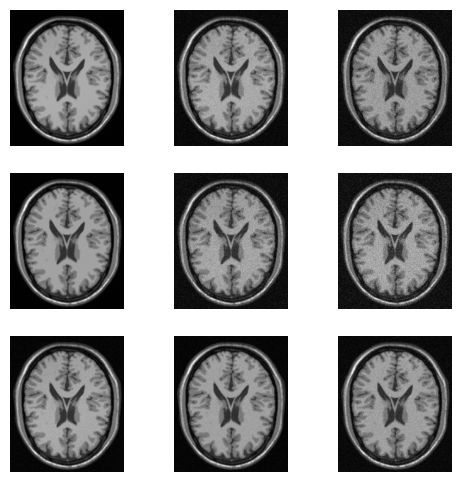

In [196]:
data = np.load('brain_dataset.npy')

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(data[i, :, :], cmap='gray')
    plt.axis('off')
plt.show()

## FCM

In [ ]:
def calculate_membership(data, centers, m):
    distances = euclidean_distances(data, centers)
    distances_power = distances ** (2.0 / (m - 1))
    inv_distances = 1.0 / distances_power
    membership = inv_distances / np.sum(inv_distances, axis=1, keepdims=True)
    return membership, distances


def calculate_centers(data, membership, m):
    um = membership ** m
    centers = np.dot(um.T, data) / np.sum(um, axis=0, keepdims=True).T
    return centers


def calculate_cost(membership, distances, m):
    u_m = membership ** m
    J = np.sum(u_m * (distances ** 2))
    return J


def FCM(data, n_clusters, m=2, max_iter=100, tol=1e-4):
    n_samples = data.shape[0]
    membership = np.random.rand(n_samples, n_clusters)
    membership /= np.sum(membership, axis=1, keepdims=True)

    J_old = np.inf
    for _ in tqdm(range(max_iter)):
        # old_membership = membership.copy()
        centers = calculate_centers(data, membership, m)
        membership, distances = calculate_membership(data, centers, m)

        # J = np.sum(np.abs(membership - old_membership))
        J_new = calculate_cost(membership, distances, m)
        if np.abs(J_new - J_old) < tol:
            print('Early Stopping...')
            break
        J_old = J_new

    return membership, centers

In [254]:
n_sample, height, width = data.shape
x = data[0].reshape(-1, 1)
n_clusters = 4
m = 2
max_iter = 100
tol = 1e-4

membership, centers = FCM(x, n_clusters, m, max_iter, tol)
membership = membership.reshape(height, width, n_clusters)
labels = np.argmax(membership, 2)

  0%|          | 0/100 [00:00<?, ?it/s]

Early Stopping...


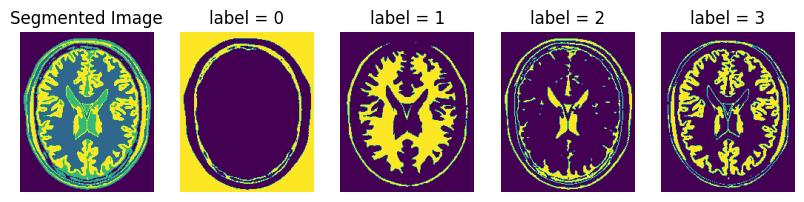

In [255]:
plt.figure(figsize=(10, 6))
plt.subplot(1, n_clusters+1, 1)
plt.imshow(labels)
plt.title('Segmented Image')
plt.axis('off')
for i in range(n_clusters):
    plt.subplot(1, n_clusters+1, i+2)
    plt.imshow(labels == i)
    plt.title('label = ' + str(i))
    plt.axis('off')
plt.show()

## WMT-FCM

In [220]:
def WMTFCM(X, C, D, m, lambda_, gamma, max_iter, tol):
    N, k, T = X.shape
    u = np.random.rand(N, C, T)
    v = np.random.rand(C, k, T)
    P = np.random.rand(C, D, T)
    z = np.random.rand(D, k)
    w = np.random.rand(D, T)
    J_old = np.inf
    for i in tqdm(range(max_iter)):
        u = calc_u(X, v, m)
        v = calc_v(X, u, m, lambda_, w, P, z)
        P = calc_P(w, v, z)
        z = calc_z(w, P, v)
        w = calc_w(P, v, z, m, lambda_, gamma)

        J_new = calc_J(X, u, m, v, w, P, z, lambda_, gamma)
        if np.abs(J_new - J_old) < tol:
            print('Early Stopping...')
            break
        J_old = J_new
    return u, v, P, z, w, J_new


def calc_J(x, u, m, v, w, P, z, lambda_, gamma):
    eps = 1e-9
    T = u.shape[2]
    J = np.zeros((T, 1))
    u_m = u ** m
    P_m = P ** m
    for t in range(T):
        dist_1 = euclidean_distances(x[:, :, t], v[:, :, t]) ** 2
        J_1 = np.sum(u_m[:, :, t] * dist_1)
        dist_2 = euclidean_distances(v[:, :, t], z) ** 2
        J_2 = np.dot(w[:, t].T, np.sum(P_m[:, :, t] * dist_2, 0).T)
        J_3 = np.dot(w[:, t].T, np.log(w[:, t] + eps))
        J[t] = J_1 + lambda_ * J_2 + gamma * J_3
    J = np.sum(J)
    return J


def calc_w(P, v, z, m, lambda_, gamma):
    T = P.shape[2]
    n_pulic_clusters = z.shape[0]
    n_private_clusters = v.shape[0]
    P_m = P ** m
    D = np.zeros((n_private_clusters, n_pulic_clusters, T))
    w = np.zeros((n_pulic_clusters, T))
    for t in range(T):
        D[:, :, t] = euclidean_distances(v[:, :, t], z) ** 2
        w[:, t] = np.sum(P_m[:, :, t] * D[:, :, t], 0).T
    w_exp_num = np.exp(-1.0 * lambda_ / gamma * w)
    w_exp_den = np.sum(w_exp_num, 1).reshape(-1, 1)
    w_exp_den[w_exp_den == 0] = 1e-9
    w = w_exp_num / w_exp_den
    return w


def calc_z(w, P, v):
    d, T = w.shape
    k = v.shape[1]
    P_m = P ** m
    z = np.zeros((d, k))
    num = np.zeros((d, k, T))
    den = np.zeros((d, T))
    for t in range(T):
        num[:, :, t] = w[:, t].reshape(-1, 1) * np.dot(P_m[:, :, t].T, v[:, :, t])
        den[:, t] = w[:, t] * np.sum(P_m[:, :, t], 0)
    z_den = np.sum(den, 1).reshape(-1, 1)
    z_den[z_den == 0] = 1e-9
    z = np.sum(num, 2) / z_den
    return z


def calc_v(x, u, m, lambda_, w, P, z):
    _, n_private_clusters, T = u.shape
    k = x.shape[1]
    u_m = u ** m
    P_m = P ** m
    v = np.zeros((n_private_clusters, k, T))
    for t in range(T):
        num_1 = np.dot(u_m[:, :, t].T, x[:, :, t])
        num_2 = np.dot(P_m[:, :, t], (w[:, t].reshape(-1, 1) * z))
        num = num_1 + lambda_ * num_2
        den_1 = np.sum(u_m[:, :, t], 0).T
        den_2 = np.dot(P_m[:, :, t], w[:, t])
        den = (den_1 + lambda_ * den_2).reshape(-1, 1)
        v[:, :, t] = num / den
    return v


def calc_P(w, v, z):
    T = w.shape[1]
    n_private_clusters = v.shape[0]
    n_pulic_clusters = z.shape[0]
    D = np.zeros((n_private_clusters, n_pulic_clusters, T))
    P = np.zeros((n_private_clusters, n_pulic_clusters, T))
    for t in range(T):
        D[:, :, t] = euclidean_distances(v[:, :, t], z)
        D_power = D[:, :, t] ** (2.0 / (m - 1))
        D_power[D_power == 0] = 1e-9
        inv_D = w[:, t] * 1.0 / D_power
        inv_D[inv_D == 0] = 1e-9
        P[:, :, t] = inv_D / np.sum(inv_D, 1).reshape(-1, 1)
    return P


def calc_u(x, v, m):
    n_samples, _, T = x.shape
    n_centers = v.shape[0]
    D = np.zeros((n_samples, n_centers, T))
    u = np.zeros((n_samples, n_centers, T))
    for t in range(T):
        D[:, :, t] = euclidean_distances(x[:, :, t], v[:, :, t])
        D_power = D[:, :, t] ** (2.0 / (m - 1))
        D_power[D_power == 0] = 1e-9
        inv_D = 1.0 / D_power
        inv_D[inv_D == 0] = 1e-9
        u[:, :, t] = inv_D / np.sum(inv_D, 1).reshape(-1, 1)
    return u

In [248]:
n_sample, height, width = data.shape
X = data.reshape(n_sample, height * width, 1)
X = np.transpose(X, (1, 2, 0))


C = 4               # number of private centers
D = 6               # number of public centers
m = 2               # fuzzy index
lambda_ = 80        # hyperparameter
gamma = 0.2         # hyperparameter
max_iter = 100      # maximum number of iterations
tol = 1e-4          # termination threshold

u, v, P, z, w, J = WMTFCM(X, C, D, m, lambda_, gamma, max_iter, tol)
m_u = u.reshape(height, width, C, n_sample)
labels = np.argmax(m_u[:, :, :, 0], 2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [253]:
def draw_table(data):
    col_width = [max(len(str(item)) for item in col) for col in zip(*data)]
    for row in data:
        print('|'.join(str(item).ljust(width) for item, width in zip(row, col_width)))
        if row == data[0]:
            print('-' * (sum(col_width) + 3 * len(col_width) - 1))

# noise_inc = [(1, 20), (5, 20), (7, 0), (1, 0), (7, 20), (9, 20), (3, 20), (3, 0), (5, 0)]

table_data = [
    ["", "Image 1", "Image 2", "Image 3", "Image 4", "Image 5", "Image 6", "Image 7", "Image 8", "Image 9"],
    ["Noise", "1", "5", "7", "1", "7", "9", "3", "5"],
    ["INU", "20", "20", "0", "0", "20", "20", "20", "0", "0"]
]

draw_table(table_data)

     |Image 1|Image 2|Image 3|Image 4|Image 5|Image 6|Image 7|Image 8
---------------------------------------------------------------------------------------
Noise|1      |5      |7      |1      |7      |9      |3      |5      
INU  |20     |20     |0      |0      |20     |20     |20     |0      


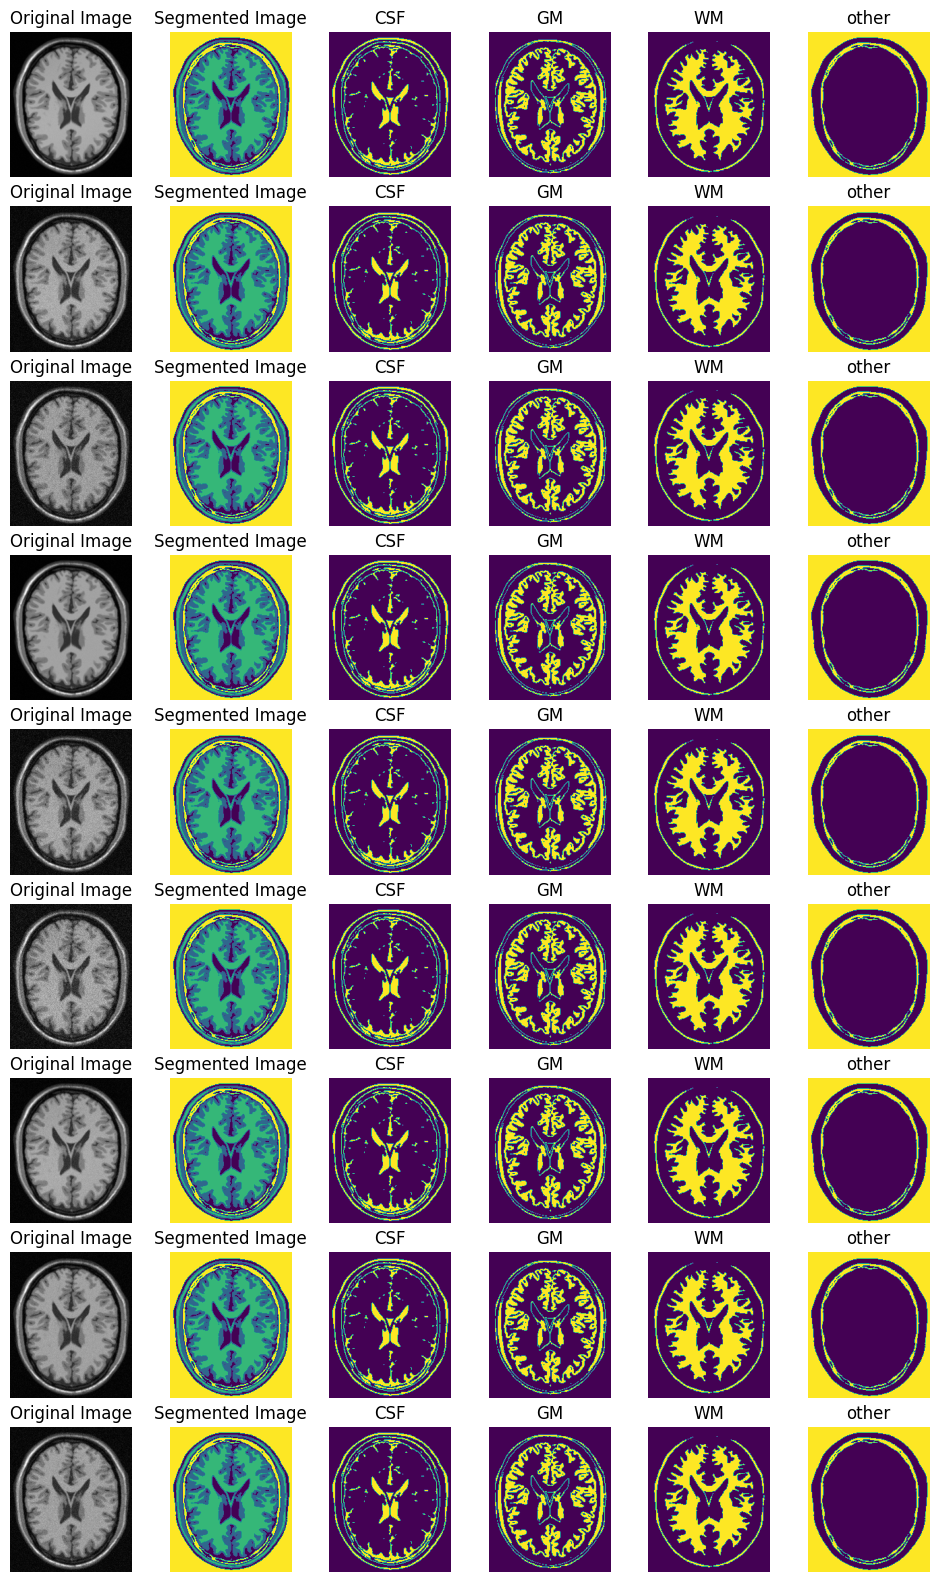

In [251]:
plt.figure(figsize=(12, 20))
for j in range(9):
    plt.subplot(9, C+2, j*(C+2)+1)
    plt.imshow(X[:, :, j].reshape(height, width), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(9, C+2, j*(C+2)+2)
    plt.imshow(labels)
    plt.title('Segmented Image')
    plt.axis('off')
    for i in range(C):
        plt.subplot(9, C+2, j*(C+2)+i+3)
        plt.imshow(labels == i)
        if i == 0:
            plt.title('CSF')
        elif i == 1:
            plt.title('GM')
        elif i == 2:
            plt.title('WM')
        else:
            plt.title('other')
        plt.axis('off')
plt.show()

In [ ]:
def dice_similarity_coefficient(segmentation, ground_truth):
    intersection = np.logical_and(segmentation, ground_truth)
    dice_coefficient = (2.0 * intersection.sum()) / (segmentation.sum() + ground_truth.sum())
    return dice_coefficient

def segmentation_accuracy(segmentation, ground_truth):
    correct_pixels = np.sum(segmentation == ground_truth)
    total_pixels = segmentation.size
    accuracy = correct_pixels / total_pixels
    return accuracy